In [1]:
import sys

# IT'S 2025 WHY HASN'T SOMEONE FIXED THIS
if ".." not in sys.path:
    sys.path.insert(0, "..")
    
from collections import defaultdict
from pathlib import Path
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from src import aposteriori
import tasks.graphs


GRAPH_DIR = Path("../graphs")

In [2]:
df = pd.read_csv(
    "../data/100_annotators.csv",
    converters={"annot_personality_characteristics": ast.literal_eval},
)
df["toxicity"] = df.annotation.apply(lambda x: x[-1]).astype(int)
df["annot_politics"] = df.annot_personality_characteristics.apply(
    lambda x: x[0]
)
df.annot_age = pd.cut(df.annot_age, bins=4)
df.message_id = df.message_id.astype(str)
df["comment_key"] = df.conv_id + df.message_id

df = df.loc[
    :,
    [
        "conv_id",
        "message_id",
        "comment_key",
        "message",
        "toxicity",
        "annot_age",
        "annot_sex",
        "annot_sexual_orientation",
        "annot_demographic_group",
        "annot_current_employment",
        "annot_education_level",
        "annot_politics",
    ],
]
df = df.groupby(["conv_id", "message_id", "comment_key", "message"]).apply(
    lambda x: pd.Series(
        {
            col: x[col].tolist()
            for col in df.columns
            if col not in ["conv_id", "message_id", "comment_key", "message"]
        }
    ),
    include_groups=False,
)
df["fake_index"] = 1
df.head(1)

,,,,toxicity,annot_age,annot_sex,annot_sexual_orientation,annot_demographic_group,annot_current_employment,annot_education_level,annot_politics,fake_index
conv_id,message_id,comment_key,message,,,,,,,,,
250cc245-86c4-4e97-a8ce-31d5d6796f71,-1428289379724132680,250cc245-86c4-4e97-a8ce-31d5d6796f71-1428289379724132680,"well thats a no brainer hillary clinton gave huma abdein a security clearance when she has ties to a known terrorist group the muslim brotherhood, and her mother runs an anti american news paper in the middle east, debbie washed up crook shultz got the awan famaily security clearances and they were recent immigrants, had absolutely no IT experience and possible ties to terrorist groups in pakistan. its pretty clear our liberal ran government is a complete and total failure when it comes to national security. 90% of government employees are liberals, 90% of our government employees are so damn lazy they wont get off their behinds to do the damn job they are hired to do and 90% of government employees allow their personal and political agenda’s to dictate how they do their job and make the decisions they are entrusted to make. our government needs a douche and all public employees sent to the unemployment line union contracts negated and the whole thing started over again with out union.\n","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[(69.75, 88.0], (33.25, 51.5], (69.75, 88.0], ...","[female, non-binary, female, male, male, male,...","[homosexual, straight, straight, straight, bis...","[black, white, asian, other, asian, other, asi...","[blue-collar, white-collar, unemployed, white-...","[university, none, university, none, universit...","[right-wing conservative, right-wing conservat...",1


In [3]:
def sample_se_vs_sample_size(
    df: pd.DataFrame,
    annotation_col: str,
    group_col: str,
    bins: int = 5,
    min_size: int = 2,
    max_size: int = 100,
    step: int = 10,
    iters: int = 30,
) -> pd.DataFrame:
    """
    Sample decreasing subsets of annotations and compute the standard error
    of polarization statistics at each sample size.

    :param df: DataFrame with annotations and factor groups.
    :param annotation_col: Column name for list of annotations.
    :param group_col: Column name for list of groups (e.g., annot_sex).
    :param bins: Number of bins for DFU.
    :param min_size: Minimum sample size to consider.
    :param max_size: Maximum sample size to consider.
    :param step: Step size to decrease sample size.
    :param iters: Repetitions per sample size for averaging.
    :return: DataFrame with columns [sample_size, standard_error]
    """
    results = []

    for size in range(max_size, min_size - 1, -step):
        se_values = []
        for _ in range(iters):
            sample_row = df.sample(1).iloc[0]
            annotations = sample_row[annotation_col]
            groups = sample_row[group_col]

            if len(annotations) < size:
                continue

            indices = np.random.choice(len(annotations), size=size, replace=True)
            sampled_annots = np.array(annotations)[indices]
            sampled_groups = np.array(groups)[indices]

            # Compute polarization statistic
            pol_stats = aposteriori._factor_polarization_stat(sampled_annots, sampled_groups, bins)
            pol_values = [v for v in pol_stats.values() if not np.isnan(v)]

            if len(pol_values) > 1:
                std_dev = np.std(pol_values, ddof=1)  # sample standard deviation
                standard_error = std_dev / np.sqrt(len(pol_values))
                se_values.append(standard_error)

        if se_values:
            results.append({"sample_size": size, "standard_error": np.mean(se_values)})

    return pd.DataFrame(results)


res_df = sample_se_vs_sample_size(
    df=df,
    annotation_col="toxicity",
    group_col="annot_sex",
    bins=5,
    min_size=3,
    max_size=100,
    step=1,
    iters=50
)
res_df

,sample_size,standard_error
0,100,0.021197
1,99,0.019359
2,98,0.027758
3,97,0.018310
4,96,0.025835
...,...,...
93,7,0.061662
94,6,0.030496
95,5,0.045139
96,4,0.028986


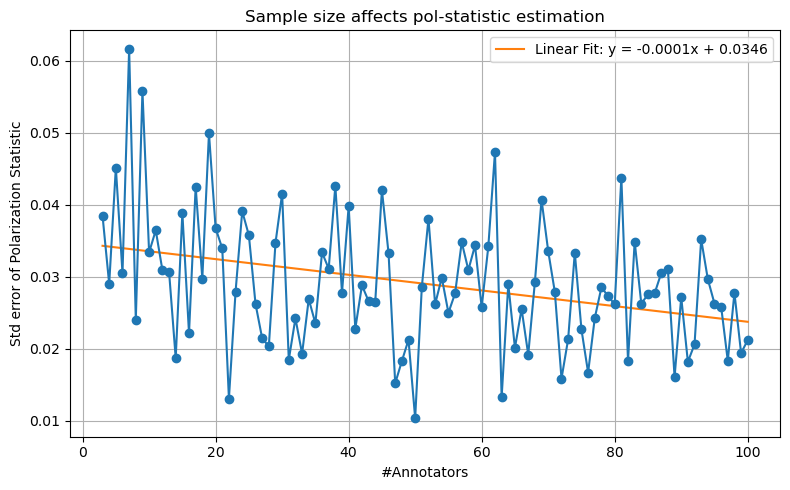

Figure saved to /home/dimits/Documents/research/aposteriori-unimodality/graphs/ndfu_std_error_sample_size.png


<Figure size 640x480 with 0 Axes>

In [4]:
def plot_variance_curve(results_df: pd.DataFrame):
    results_df = results_df.sort_values("sample_size")

    x = results_df["sample_size"].values.reshape(-1, 1)
    y = results_df["standard_error"].values

    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    plt.figure(figsize=(8, 5))
    plt.plot(
        x,
        y_pred,
        label=f"Linear Fit: y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}",
        color="tab:orange",
    )
    plt.plot(x, y, color="tab:blue", marker="o")
    plt.xlabel("#Annotators")
    plt.ylabel("Std error of Polarization Statistic")
    plt.title("Sample size affects pol-statistic estimation")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example usage
plot_variance_curve(res_df)
tasks.graphs.save_plot(GRAPH_DIR / "ndfu_std_error_sample_size.png")